In [49]:
#%pip install tfds-nightly
#%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.dpi": 120, "figure.figsize": (10, 5)})
dfs = {}
datasets = ["CivilComments", "Cyberbullying", "MeToo", "HS Tweets", "MultiTarget", "Toraman22", "GHC"]

CivilComments

In [50]:
dfs["CivilComments"] = pd.read_csv("CivilComments/data.csv")

# Cell 3: parse created_date which may be bytes (e.g., b'2016-11-29 ...')
def parse_created_date(val):
    # decode bytes if needed and coerce to datetime (UTC)
    if isinstance(val, (bytes, bytearray)):
        s = val.decode("utf-8")
    else:
        s = str(val)
    # Some entries may already be 'YYYY-MM-DD ...' strings; this will handle them
    return pd.to_datetime(s, errors="coerce", utc=True)

# Apply parsing
dfs["CivilComments"]["created_date"] = dfs["CivilComments"]["created_date"].apply(parse_created_date)

# Drop rows with invalid dates
dfs["CivilComments"] = dfs["CivilComments"].dropna(subset=["created_date"]).reset_index(drop=True)

dfs["CivilComments"]["class"] = dfs["CivilComments"]["toxicity"].apply(lambda t: "Hate" if t > 0.5 else "Non-Hate")
dfs["CivilComments"]["month"] = dfs["CivilComments"]["created_date"].dt.to_period("M")

print(f"Rows: {len(dfs['CivilComments'])}")

Rows: 1999516


c:\Users\Dario\miniconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


MeToo

In [51]:
# Cell 3
dfs["MeToo"] = pd.read_csv("MeToo/data.csv")

# Parse created_at as datetime (UTC)
dfs["MeToo"]["created_at"] = pd.to_datetime(dfs["MeToo"]["created_at"], errors="coerce", utc=True)

# Drop rows with invalid dates
dfs["MeToo"] = dfs["MeToo"].dropna(subset=["created_at"]).reset_index(drop=True)

dfs["MeToo"]["month"] = dfs["MeToo"]["created_at"].dt.to_period("M")

# Generate Classes
dfs["MeToo"]["class"] = dfs["MeToo"]["category"].map({0: "Non-Hate", 1: "Hate"})

print(f"Rows: {len(dfs['MeToo'])}")

Rows: 807174


HS Tweet

In [52]:
hst_classes = ["Hate", "Normal", "Offensive"]
hst_dfs = []

for cls in hst_classes:
    for i in range(1, 5):  # files 1 to 4
        file_name = f"HS Tweets/{cls}_Speeches_{i}.csv"
        tmp = pd.read_csv(file_name, usecols=["created_at"])
        tmp["class"] = cls
        hst_dfs.append(tmp)

# Combine all files into a single DataFrame
dfs["HS Tweets"] = pd.concat(hst_dfs, ignore_index=True)

dfs["HS Tweets"]["created_at"] = pd.to_datetime(dfs["HS Tweets"]["created_at"], errors="coerce", utc=True)

# Drop invalid dates
dfs["HS Tweets"] = dfs["HS Tweets"].dropna(subset=["created_at"]).reset_index(drop=True)


dfs["HS Tweets"]["class"] = dfs["HS Tweets"]["class"].map({"Normal": "Non-Hate", "Hate": "Hate", "Offensive": "Hate"})
dfs["HS Tweets"]["month"] = dfs["HS Tweets"]["created_at"].dt.to_period("M")

print(f"Rows: {len(dfs['HS Tweets'])}")

Rows: 3061


MultiTarget

In [53]:
dfs["MultiTarget"] = pd.read_csv("MultiTarget/data.csv")

dfs["MultiTarget"]["CreateDate"] = pd.to_datetime(dfs["MultiTarget"]["CreateDate"], errors="coerce", utc=True)

def assign_class_simple(row):
    if row.get("Biased") == 1:
        return "Hate"
    if row.get("Calling_Out") == 1:
        return "Hate"
    return "Non-Hate"

dfs["MultiTarget"]["class"] = dfs["MultiTarget"].apply(assign_class_simple, axis=1)

# Create year_month column
dfs["MultiTarget"]["month"] = dfs["MultiTarget"]["CreateDate"].dt.to_period("M")

print(f"Rows: {len(dfs['MultiTarget'])}")

Rows: 11243


c:\Users\Dario\miniconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Toraman22

In [54]:
dfs["Toraman22"] = pd.read_csv("Toraman22/v2.tsv", sep="\t")

# English Only
dfs["Toraman22"] = dfs["Toraman22"][dfs["Toraman22"]["language"] == 1].copy()


# parse date column
dfs["Toraman22"]["date"] = pd.to_datetime(dfs["Toraman22"]["date"], errors="coerce")
dfs["Toraman22"] = dfs["Toraman22"].dropna(subset=["date"])  # drop rows with invalid dates
dfs["Toraman22"]["month"] = dfs["Toraman22"]["date"].dt.to_period("M")

def assign_class(row):
    votes = {
        "Non-Hate": row["label_0"],
        "Hate": row["label_2"] + row["label_1"]
    }
    max_vote = max(votes.values())
    candidates = [cls for cls, v in votes.items() if v == max_vote]

    if "Hate" in candidates: # prefer Hate in case of tie
        return "Hate"
    
    return "Non-Hate"

dfs["Toraman22"]["class"] = dfs["Toraman22"].apply(assign_class, axis=1)
print(f"Rows: {len(dfs['Toraman22'])}")

c:\Users\Dario\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3577: DtypeWarning: Columns (0,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Rows: 102066


GHC

In [69]:
import numpy as np

df1 = pd.read_csv('GHC/ghc_train.tsv', sep='\t')
df2 = pd.read_csv('GHC/ghc_test.tsv', sep='\t')

dfs["GHC"] = pd.concat([df1, df2], ignore_index=True)
dfs["GHC"]["class"] = pd.DataFrame(np.where( (dfs["GHC"]["hd"] + dfs["GHC"]["cv"] + dfs["GHC"]["vo"]  > 0), "Hate", "Non-Hate")) # If the row has at least one hate label, it is classified as Hate

dfs["GHC"]["month"] = pd.to_datetime(f"2018") # We are just showing yearly distribution for now


print(f"Rows: {len(dfs['GHC'])}")

Rows: 27546


In [74]:
df = pd.concat(dfs.values(), ignore_index=True)
df["class"].value_counts()

Non-Hate    2714451
Hate         236155
Name: class, dtype: int64

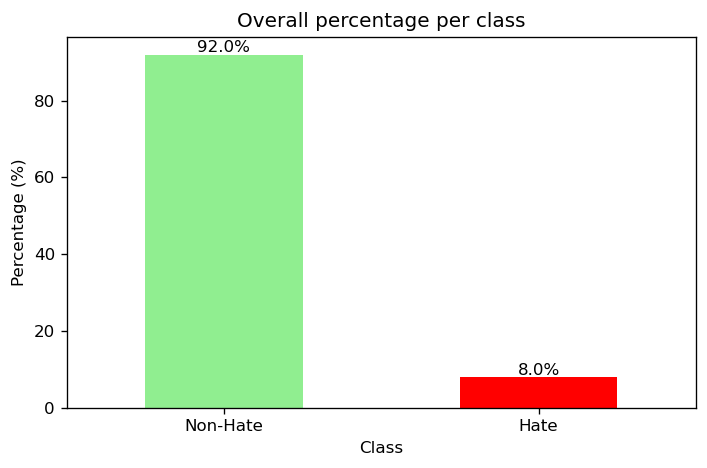

In [71]:
class_percent = df["class"].value_counts(normalize=True).reindex(["Non-Hate", "Hate"]).fillna(0) * 100
colors = {"Non-Hate": "lightgreen", "Hate": "red"}

plt.figure(figsize=(6,4))
class_percent.plot(kind="bar", color=[colors[k] for k in class_percent.index])
plt.title("Overall percentage per class")
plt.ylabel("Percentage (%)")
plt.xlabel("Class")
plt.xticks(rotation=0)
for i, v in enumerate(class_percent):
    plt.text(i, v + 0.6, f"{v:.1f}%", ha="center")
plt.tight_layout()
plt.show()

### Yearly charts (Hate label only)

In [80]:
# Combine all dataframes with dataset labels
all_data = []
for dataset_name, df in dfs.items():
    df_temp = df[df['class'] == 'Hate'].copy()    
    df_temp['year'] = df_temp['month'].dt.strftime('%Y')
    df_temp['dataset'] = dataset_name
    all_data.append(df_temp[['year', 'dataset']])

# Concatenate all data
combined_df = pd.concat(all_data, ignore_index=True)

# Count by year and dataset, then calculate percentages
yearly_counts = combined_df.groupby(["year", "dataset"]).size().unstack(fill_value=0).sort_index()
yearly_percent = yearly_counts.div(yearly_counts.sum(axis=1), axis=0) * 100

# Define colors for each dataset
colors = {
    "CivilComments": "#1f77b4",
    "Cyberbullying": "#ff7f0e", 
    "MeToo": "#2ca02c",
    "HS Tweets": "#d62728",
    "MultiTarget": "#9467bd",
    "Toraman22": "#8c564b",
    "GHC": "#e377c2"
}

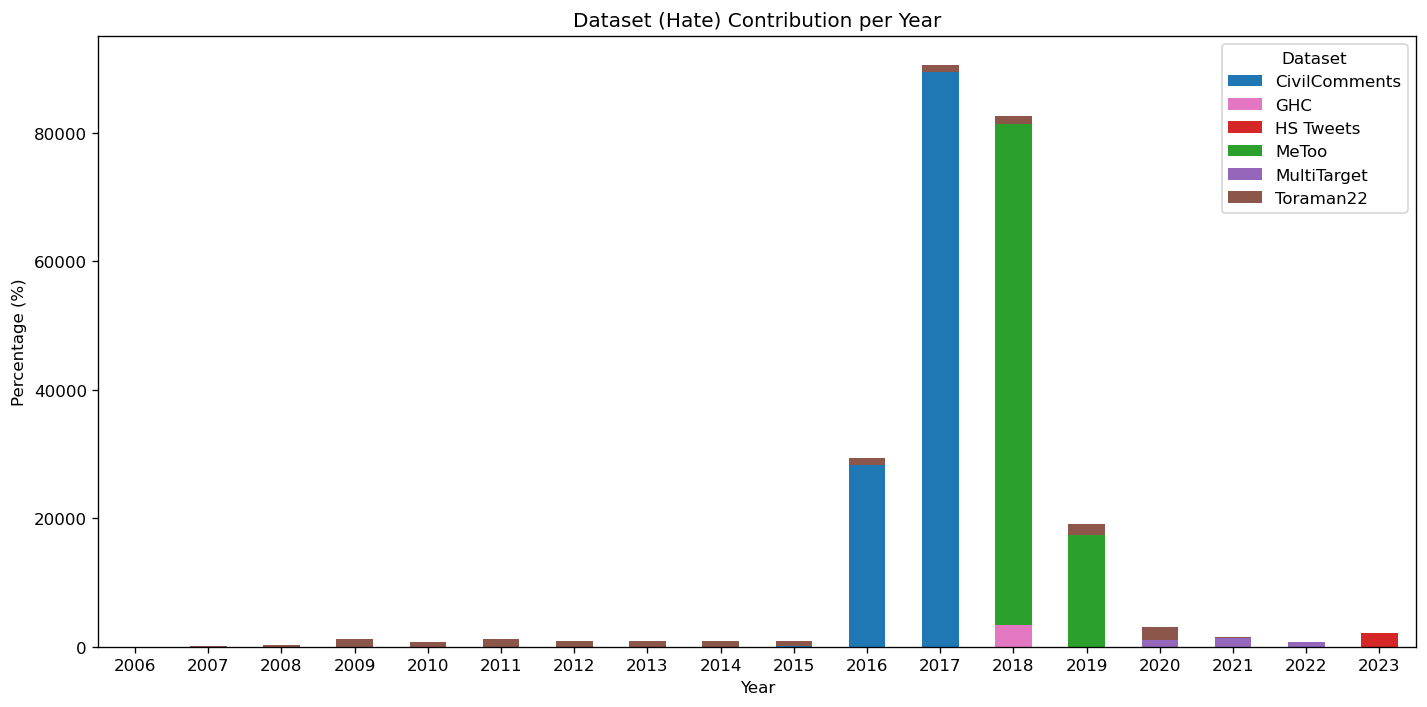

In [ ]:
# Create the plot
yearly_counts.plot(kind="bar", stacked=True, figsize=(12, 6), color=colors)

plt.title("Dataset (Hate) Contribution per Year")
plt.ylabel("Number of Hate Samples")
plt.xlabel("Year")
plt.xticks(rotation=0)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

### Notes
- 2006 - 2008 Toraman it's pretty much noise, and has 35% of the data in 2019
- HS Tweets it's basically spread in 10 of February
- CivliComments + MeToo cover 95% of data (can be ok for CC but not for MeToo)
- SemEval and WhiteSupremacy have been excluded because timespans are too wide to maky any assumptions (decades)
- DigHist has it's own chart for a similar reason
- The charts are for Hate label only, although the distribution of classes per dataset it's somehow similar (between 6% and 15%), considering full datasets would make the difference in number of rows even worse


### Type of Datasets
We have 3 types of  diacrhonic datasets (based on labelling and split) that could use
- Hate Labelled (basically all the ones in the charts above)
- LSC (Dataset is given with target words but not labelled)
- Pure Diachronic (Just large scale corpora with wide timespan such as PleIAs/common_corpus, PleIAs/US-PD-Newspapers or many others available here https://www.english-corpora.org/corpora.asp)
There are very afew LSC datasets available (the way I define them)

## Fusion approaches
The proposed approaches depend heavily on the final task, since it will define the labels we will need and the training approach.

- **Hate label trough time** 
<br>Due to the lack of targets this would be easiest approach. It can allow us to do some post processing to mitigate distribution of both classess and targets.<br>

- **Words through time**
<br>This would be more oriented to a pure LSCD task since we need the lexicon which is the main focus.<br>

- **Time based**
<br>Splitting in time slots sounds promising if we want to proof that we don't need to explicitly train a model on LSC task to perform better, we could just try CLM training and see what happens<br>


### Extra resources 
These resources could be helpful
- https://github.com/Garrafao/LSCDetection/tree/master?tab=readme-ov-file#pre-training Repository for LSCD task where datasets were collected, there are also evaluation metrics that could be used in the future
-  https://github.com/lexibank/datsemshift  lexicon of shifted meaning word (on the first read i couldn't find the timespan used to define the change). Very reliable work since the research group has published several paper on the topic and has released a very famous Russian LSC dataset.
- https://aclanthology.org/2022.lrec-1.228.pdf paper from Montreal University about how to build a LSC dataset (how to build the lexicon). The procedure seems very time consuming to me but i just gave a quick look. They build a french so Farah could understand things better.
- https://nlp.stanford.edu/projects/histwords/ Historical Embedding
- twint is dead

### Task idea: MoTE + next embedding generation (https://arxiv.org/pdf/2310.10688)
<br>We might won't need lexicon in training, in between embedding comparison and definition generation. An interesting training idea (for decoder) could be, given a word/definition from time n, generate using experts until time n-1 and use as gold label the given word/definition or generate one from n-th expert.